# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # Often used alongside Seaborn
from sklearn.preprocessing import StandardScaler

In [129]:
df=pd.read_csv('data/vehicles.csv')

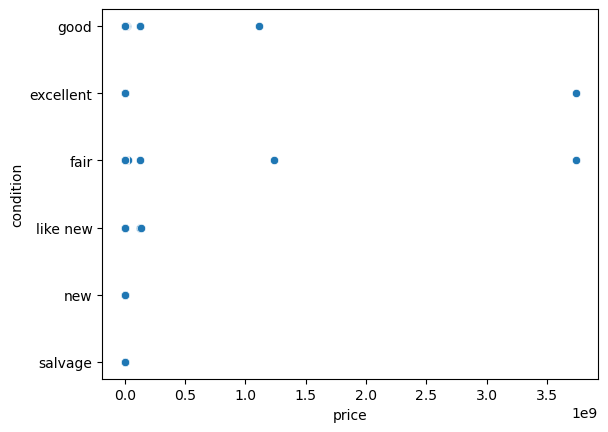

In [131]:
ax=sns.scatterplot(x='price',y='condition', data=df)

# While the general trend is clear, there's still a spread of prices within each condition category. 
# This suggests that other factors beyond just the broad condition categories might also 
# influence the final price (e.g., specific features, make/model if it were cars, mileage, etc.)
plt.show()

In [134]:
df.query('condition=="excellent" & odometer <20000 & price < 50000')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
240,7316229137,birmingham,23500,1970.0,chevrolet,monte carlo,excellent,NaN,gas,18678.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,al
428,7314355049,birmingham,0,2020.0,dodge,charger,excellent,8 cylinders,gas,8428.0,clean,automatic,2C3CDXGJ8LH129343,rwd,NaN,sedan,NaN,al
431,7314347283,birmingham,0,2021.0,nissan,titan xd,excellent,8 cylinders,gas,2576.0,clean,automatic,1N6AA1FBXMN506733,4wd,NaN,truck,black,al
441,7314277945,birmingham,24888,2019.0,ford,f150 regular cab xl,excellent,6 cylinders,gas,8176.0,clean,automatic,NaN,rwd,full-size,pickup,white,al
606,7313029336,birmingham,34900,2020.0,nissan,pathfinder,excellent,6 cylinders,gas,15400.0,clean,automatic,5N1DR2DN2LC622798,rwd,full-size,SUV,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426167,7304331050,wausau,40998,2019.0,ford,t-350 hd,excellent,6 cylinders,gas,18955.0,clean,automatic,NaN,rwd,full-size,truck,red,wi
426217,7302846619,wausau,21370,2017.0,chevrolet,traverse,excellent,6 cylinders,gas,19429.0,rebuilt,automatic,NaN,4wd,mid-size,SUV,black,wi
426245,7302193972,wausau,16995,2014.0,ford,transit connect,excellent,4 cylinders,gas,18752.0,clean,automatic,NaN,fwd,compact,van,white,wi
426316,7315967944,wyoming,25500,1952.0,NaN,520dodge,excellent,8 cylinders,gas,5000.0,clean,automatic,NaN,rwd,full-size,NaN,orange,wy


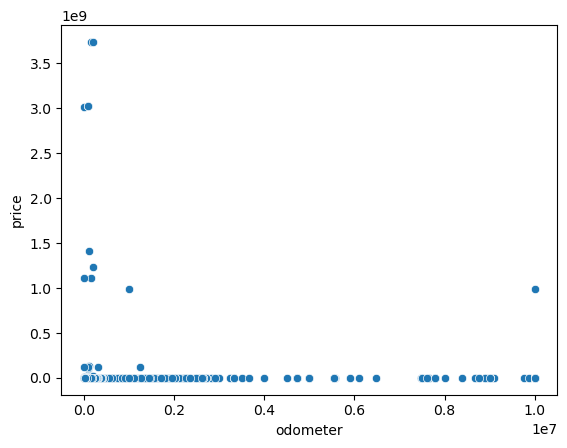

In [127]:
ax=sns.scatterplot(x='odometer',y='price', data=df)

plt.show()

In [117]:
df['condition'].value_counts()
df['model'].value_counts() #5139 different models
df['title_status'].value_counts() 
#6 statueses. Clean(405117), rebuilt(7219) ,salvage 3868, lien(1422), missing (814), parts only(198)

#print(len(df))
df['transmission'].value_counts() 
# automatic(336524) , other(62682) , manual(25118)
df['year'].value_counts() 
df['drive'].value_counts() 
#print(len(df[df['drive'].isnull()]))
# 4wd(16565), fwd(10950), rwd(7353)

df['size'].value_counts() 
#full-size  20267   mid-size  9896  compact   4060          compact 4060

df['type'].value_counts() 
#SUV 9278, sedan 8249,truck 7692,pickup 2764,van 1754,coupe 1493, hatchback 1133,wagon 837,
# convertible 824, mini-van 619,other 99,offroad 83,bus 43

df['paint_color'].value_counts() 
#paint_color
#white     9862
#black     6510
#silver    4769
#grey      4185
#blue      3344
#red       3129
#custom     901
#green      871
#brown      835
#yellow     230
#orange     160
#purple      72

df['fuel'].value_counts()

#fuel?
#df.head()


fuel
gas         31313
diesel       3019
hybrid        425
electric       79
other          32
Name: count, dtype: int64

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [85]:
df=df.dropna()

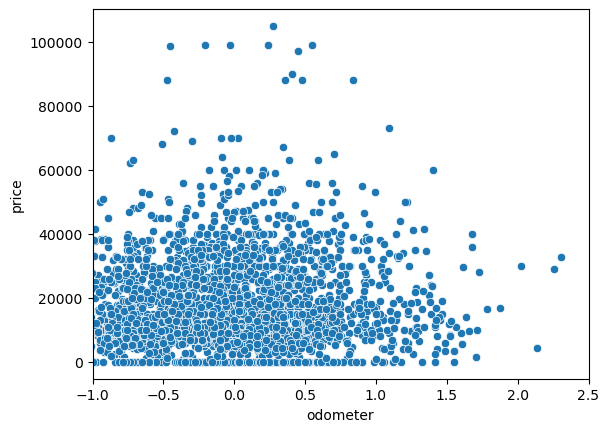

In [86]:
scaler = StandardScaler()
df_odo_scaled = pd.DataFrame(scaler.fit_transform(df[['odometer']]), columns=['odometer'])
df_scaled = pd.concat([df[['price']],df_odo_scaled],axis='columns') 

ax=sns.scatterplot(x='odometer',y='price', data=df_scaled)
plt.xlim(-1.0, 2.5)
plt.show()

In [67]:
iqr = ''

###BEGIN SOLUTION

first_quartile = df['odometer'].quantile(.25)
third_quartile = df['odometer'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr

outliers_filtered = df.loc[(df['odometer']>lower) & (df['odometer']<upper)]
print(len(outliers_filtered))
# count in salaries_no_outlier 34516
# while count in original df is 34868. So we managed to remove 350 outliers.

34516


In [63]:
price_null_rows=outliers_filtered[outliers_filtered['price'].isnull()]
print(len(price_null_rows))

32028


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.